# Test file

## Load the dataset

In [1]:
from src.preprocess_data import preprocess_dataset,pca_dataset

ImportError: cannot import name 'pca_dataset' from 'src.preprocess_data' (d:\Uni\Neurocognitive Computing\Neurocog\src\preprocess_data.py)

## Investigate the dataset features



In [1]:
from bokeh.transform import linear_cmap
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, ColorBar, LinearColorMapper
from bokeh.models import Arrow, NormalHead, LabelSet, Label
from bokeh.plotting import figure, output_notebook, show
from bokeh.transform import  linear_cmap
from bokeh.core.properties import value
from bokeh.models.tickers import FixedTicker
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.palettes import Category10, Category20, Viridis

from sklearn.decomposition import IncrementalPCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns

output_notebook()

Loading BokehJS ...

In [2]:
file_names =  ["p{}_d1".format(p) for p in range(1,11,1)] + ["p{}_d1".format(p) for p in range(1,11,1)]
dfs = [pd.read_csv("data/" + f + ".csv").drop(labels=["#timestamp","date_time"], axis=1) for f in file_names]
condensed = None


First make a corelation matrix, to see, how features correlate

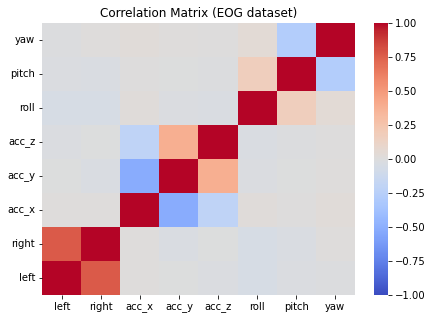

In [3]:
def dfs_correlation(dfs : pd.DataFrame, condensed = None):
    if condensed is None:
        array = np.empty([0,8,8])
        for df in dfs:
            # compute Pearson correlation
            corr = df.drop("label", axis=1).corr()

            array = np.concatenate((array, np.expand_dims(corr.to_numpy(),0)))
            
            
        condensed = pd.DataFrame(np.flip(np.mean(array, axis = 0), axis=0),columns=corr.columns, index = corr.index[::-1])
    fig,ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title("Correlation Matrix (EOG dataset)")
    sns.heatmap(data = condensed , vmin=-1,vmax=1, cmap = "coolwarm" )

    plt.yticks(rotation=0)
    plt.savefig("res/correlation_matrix.png")
    plt.savefig("res/correlation_matrix.pdf")
    plt.show()
    return condensed


condensed = dfs_correlation(dfs, condensed) 
plt.close()


Now we calculate the PCA vectors

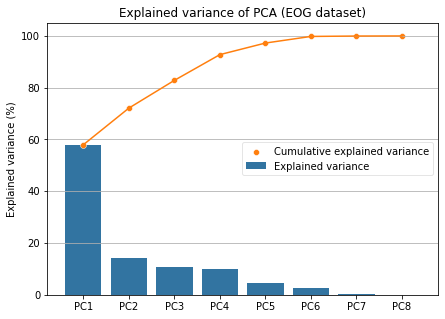

In [4]:
def dfs_PCA(dfs):
    pca = IncrementalPCA()
    
    for df in dfs:
        pca.partial_fit(df.to_numpy()[:,:-1])

    var_exp = pca.explained_variance_ratio_*100
    cum_var_exp = np.cumsum(var_exp)
    x = ['PC%s' %(i+1) for i in range(len(df.columns)-1)]

    source = pd.DataFrame( dict(x=x, var_exp=var_exp, cum_var_exp=cum_var_exp) )

    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title("Explained variance of PCA (EOG dataset)")

    
    sns.barplot(data=source, x="x", y="var_exp", color = "tab:blue", label="Explained variance")
    sns.lineplot(data=source, x="x", y="cum_var_exp", color = "tab:orange")
    sns.scatterplot(data=source, x="x", y="cum_var_exp" , color = "tab:orange", label="Cumulative explained variance")
    

    plt.legend(fancybox=True, framealpha = 0.5)
    ax.grid(True,axis="y")
    ax.set_ylabel("Explained variance (%)")
    ax.set_xlabel("")
    plt.savefig("res/PCA_explanation.png")
    plt.savefig("res/PCA_explanation.pdf")
    plt.show()

dfs_PCA(dfs)
    
        

Do a scatter plot (only with PC1 & PC2) and show PCA dimensions.

In [10]:
def scatter_PCA(df : pd.DataFrame):
    
    df_std = StandardScaler().fit_transform(df.drop("label", axis = 1))

    # store PCA in variable pca
    pca = PCA().fit(df_std)
    
    pca_df = pd.DataFrame( pca.transform(df_std), columns=['PC%i' % (i+1) for i in range(pca.n_components_)])
    pca_df["label"] = df.label
    
    # get the different classes in the Type variable
    factors = [0,1,2,3]
    
    source = ColumnDataSource(pca_df)

    p = figure( plot_width=600, plot_height=600, toolbar_location=None, 
                title="Projection onto first two principal components")

    p.circle( source=source, x='PC1', y='PC2', size=9, legend_group='label',
             color=linear_cmap('label', palette=Category10[10], low = 0, high = 3)
             )
    p.xaxis.axis_label = 'PC1' 
    p.yaxis.axis_label = 'PC2' 

    scale = 10
    offset = [
        (-35,-20),(-35,-10),(45,-50),(-5,10),
        (-5,-25),(0,5),(-30,-5),(-30,-40),
        ]
    for f in range(len(pca.components_)):
        p.add_layout(Arrow(x_start=0, y_start = 0, x_end = pca.components_[:,f][0]*scale, y_end = pca.components_[:,f][1]*scale,
                    line_alpha = 0.7, line_width = 1.3, end=NormalHead(line_alpha=0.5, fill_alpha = 0.5,  size = 10,)))
        p.add_layout(Label(x=pca.components_[:,f][0]*scale, y = pca.components_[:,f][1]*scale, text = df.columns[f], text_align = "center",
                   #     x_offset = offset[f][0], y_offset = offset[f][1]  
                        ) )
    
    show(p)


#scatter_PCA(df_scrub[:100000:100])